In [1]:
from PIL import Image
import cv2 as cv
import numpy as np
from ultralytics import SAM
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from joblib import delayed, Parallel
import multiprocessing

In [2]:
images_pths = [str(path.absolute()) for path in Path('./custom_dataset').iterdir()]

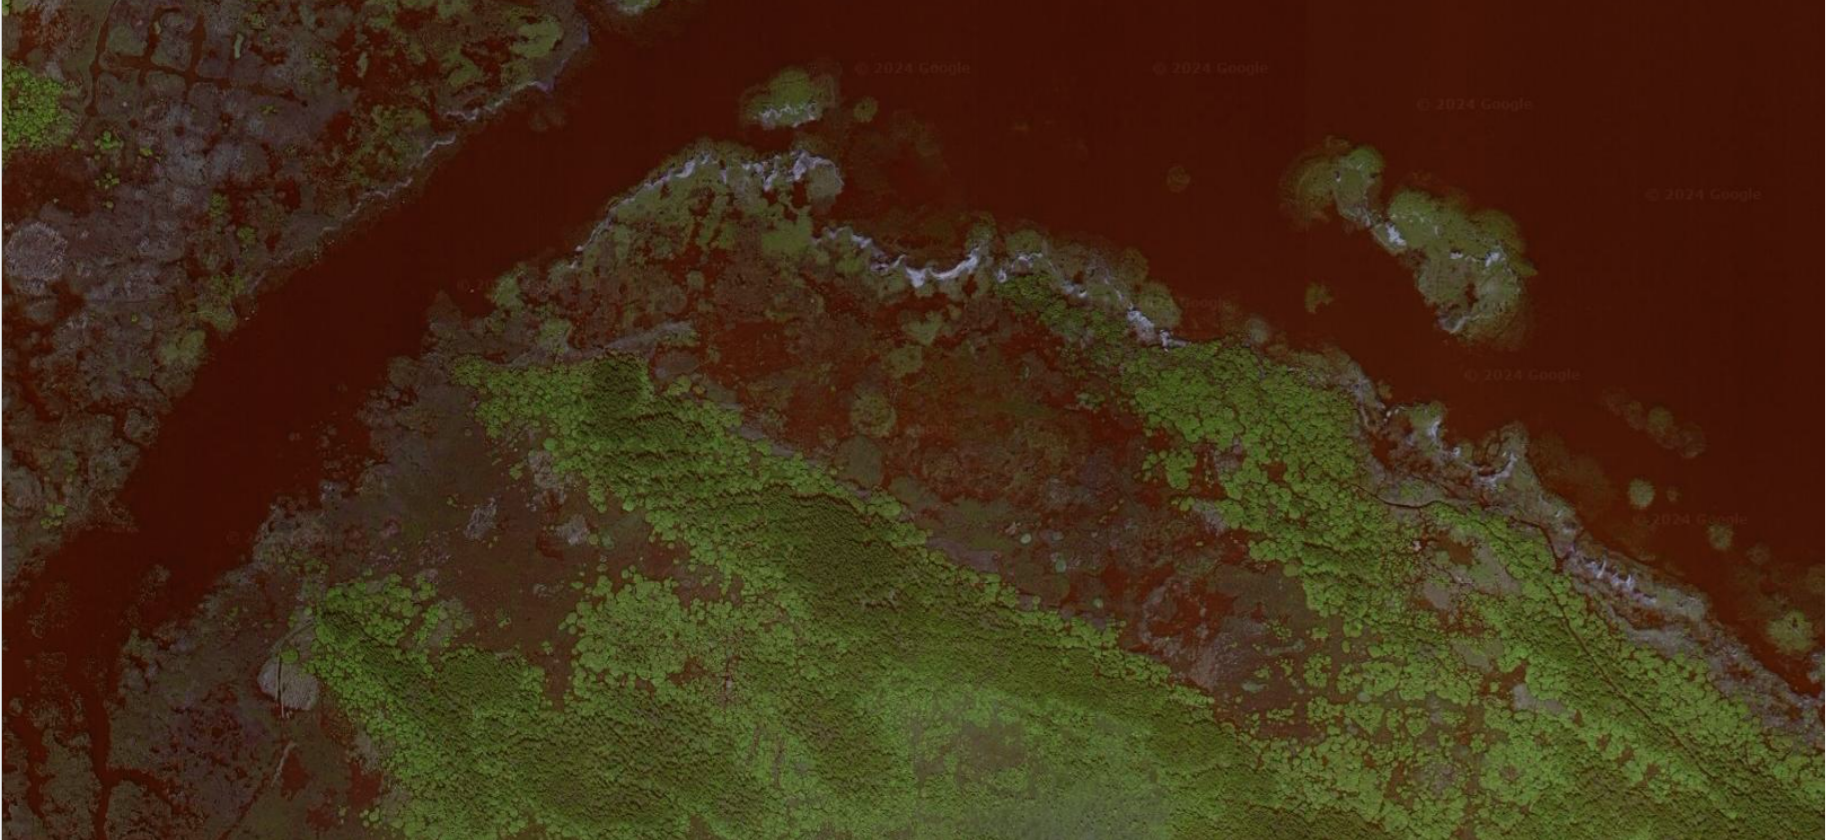

In [3]:
img = cv.imread(images_pths[0])
Image.fromarray(img)

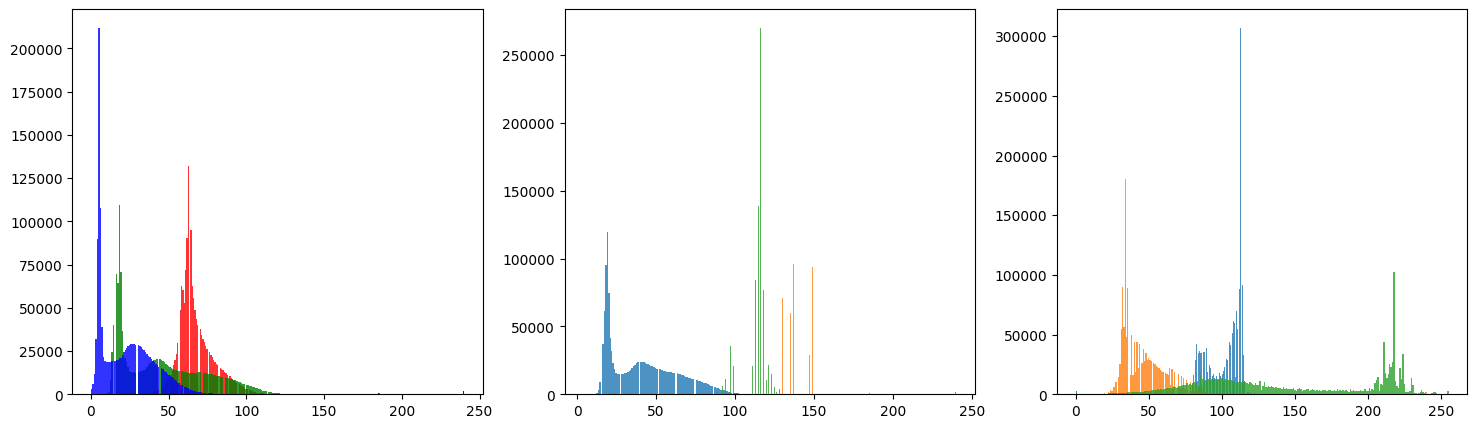

In [4]:
r, g, b = map(np.array, Image.fromarray(img).split())

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,5))

ax1.hist(r.ravel(), bins=256, alpha=0.8, color='red')
ax1.hist(g.ravel(), bins=256, alpha=0.8, color='green')
ax1.hist(b.ravel(), bins=256, alpha=0.8, color='blue')

y,u,v = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2YUV)).split())

ax2.hist(y.ravel(), bins=256, alpha=0.8)
ax2.hist(u.ravel(), bins=256, alpha=0.8)
ax2.hist(v.ravel(), bins=256, alpha=0.8)

h, l, s = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2HLS)).split())
ax3.hist(h.ravel(), bins=256, alpha=0.8)
ax3.hist(l.ravel(), bins=256, alpha=0.8)
ax3.hist(s.ravel(), bins=256, alpha=0.8)

plt.show()

In [10]:
def coords_processing(mask, coords):
    coastline_coords = []
    row, col = mask.shape

    for coord in coords:
        r, c = coord[0], coord[1]
        neighbours = []

        for j in range(r - 1, r + 2):
            for k in range(c - 1, c + 2):
                if (0 <= j < row) and (0 <= k < col) and j != r and k != c:
                    neighbours.append(int(mask[j][k]))

        if any([neigh not in [1,3,5] for neigh in neighbours]):
            coastline_coords.append((r, c))

    return coastline_coords

In [38]:
def get_coastlines(img : np.ndarray, mask : np.ndarray):
    if mask.shape.__len__() >= 3:
        raise ValueError('Expected 2-dim mask')


    PROCESS_COUNT = 20
    
    row, col = mask.shape


    coastlines_coord = []
    coords = np.argwhere(mask == 5)

    print(f'Mask shape {mask.shape} | Coordinates count : {coords.shape[0]} | Expected time : {coords.shape[0] * 9 / 1e6 }s')

    one_range = len(coords) // PROCESS_COUNT
    ranges = [(one_range * i, one_range * (i + 1)) for i in range(PROCESS_COUNT - 1)]
    ranges += [(ranges[-1][1], len(coords))]

    values = Parallel(n_jobs=PROCESS_COUNT)(delayed(coords_processing)(mask, coords[r[0] : r[1]]) for r in ranges)        
    for val in values:
        coastlines_coord.extend(val)

    return np.array(coastlines_coord)

In [58]:
lables = [str(path.absolute()) for path in Path('./floodnet/test/label').iterdir()]
imgs = [str(path.absolute()) for path in Path('./floodnet/test/img').iterdir()]

mask = cv.imread(lables[50])
img = cv.imread(imgs[50])

mask = mask[:, :, 0]
get_coastlines(img, mask)

Mask shape (3072, 4592) | Coordinates count : 1957581 | Expected time : 17.618229s


array([[   1, 1690],
       [   1, 1691],
       [   2, 1691],
       ...,
       [3069,  489],
       [3069,  490],
       [3069,  491]], dtype=int64)